<a href="https://colab.research.google.com/github/ThaoPham96/DeepARV/blob/main/DeepARV_Chemberta_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DeepARV: Ensemble Deep Learning to Predict Drug-Drug Interaction (DDI) of Clinical Relevance with Antiretrovial Therapy (ARV)**

In this study, we built an esemble learning algorithm to predict DDIs of clinical relevance between ARVs and comedications.

DDI severity grading between 29,142 drug pairs was extracted from the Liverpool HIV Drug Interaction database, https://www.hiv-druginteractions.org/. Molecular structure of each drug was converted to Morgan fingerprints where each atom was represented in a numerical format and compared by constructing drug similarity profiles. We developed DeepARV, a feed-forward neural network where drug similarity profiles were fed into the input layer and outputted 4 categories of DDI as 'traffic light' system:

*   Red: drugs should not be co-administered
*   Amber: interaction of potential clinical relevance manageable by monitoring/dose adjustment
*   Yellow: interaction of weak relevance
*   Green: no expected interaction

The imbalance in the distribution of DDI severity grades was addressed by undersampling and applying ensemble learning during training of DeepARV.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and installations

In [2]:
!pip install tensorboard
!pip install tensorflow_addons

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.callbacks import Callback
import tensorflow.experimental.numpy as tnp
import math
import timeit
import datetime, os
import pandas as pd
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.utils import class_weight
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm import tqdm
from deep_arv_utils import *
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

# DeepARV Class

In [4]:
def get_weighted_metrics(y_pred, y_test):
    confusion_matrix = tf.math.confusion_matrix(y_test,y_pred, 4)
    num_instances_per_class = np.bincount(y_test)
    TP = np.diag(confusion_matrix)
    FP = np.sum(confusion_matrix, axis=0) - TP
    FN = np.sum(confusion_matrix, axis=1) - TP
    TN = np.sum(confusion_matrix) - (TP + FP + FN)
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    balanced_accuracy = (sensitivity + specificity) / 2
    # Calculate weighted averages
    weighted_avg_precision = np.sum(precision * num_instances_per_class) / np.sum(num_instances_per_class)
    weighted_avg_sensitivity = np.sum(sensitivity * num_instances_per_class) / np.sum(num_instances_per_class)
    weighted_avg_specificity = np.sum(specificity * num_instances_per_class) / np.sum(num_instances_per_class)
    weighted_avg_f1_score = np.sum(f1_score * num_instances_per_class) / np.sum(num_instances_per_class)
    weighted_avg_balanced_accuracy = np.sum(balanced_accuracy * num_instances_per_class) / np.sum(num_instances_per_class)
    macro_accuracy = np.mean(accuracy, axis=0)
    weighted_array = np.array([macro_accuracy, weighted_avg_precision,
                               weighted_avg_sensitivity, weighted_avg_specificity,
                          weighted_avg_f1_score, weighted_avg_balanced_accuracy])
    metrics_sum = np.vstack((accuracy, precision, sensitivity, specificity,
                            f1_score, balanced_accuracy)).T
    metrics_update = np.vstack((metrics_sum,weighted_array))
    columns = ['accuracy', 'precision', 'sensitivity', 'specificity', 'f1-score',
               'balanced accuracy']
    rows = ['Green','Yellow', 'Amber', 'Red', 'Weighted']
    df = pd.DataFrame(data = metrics_update, columns = columns, index = pd.Index(rows))
    print("Weighted Avg Precision", weighted_avg_precision)
    print("Weighted Avg Sensitivity", weighted_avg_sensitivity)
    print("Weighted Avg Specificity", weighted_avg_specificity)
    print("Weighted Avg F1 Score", weighted_avg_f1_score)
    print("Weighted Avg Balanced Accuracy", weighted_avg_balanced_accuracy)
    return df

In [15]:
class DeepARV_ensemble:
  ''' Training of DeepARV '''
  def __init__(self, train_df=None, test_df=None, n_models=5):
    # Load data
    self.train_df = train_df
    self.test_ds = test_df
    self.n_models = n_models

  def build_model(self, feature):
    ''' Builds a single model '''
    model = Sequential()
    model.add(Dense(256, activation='tanh', input_shape=(feature,))),
    model.add(Dropout(0.2)),
    model.add(Dense(128, activation='tanh')),
    model.add(Dropout(0.2)),
    model.add(Dense(4, activation='softmax'))
    tf.keras.optimizers.Adam(learning_rate=0.001,
                            beta_1=0.9, beta_2=0.999,
                            epsilon=1e-07,
                            amsgrad=False,
                            name='Adam')
    model.compile(optimizer='Adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    self.model = model
    return model

  #Undersample the majority
  def undersample(self ):
      minority = self.train_df[self.train_df.Label != 0]
      majority = self.train_df[self.train_df.Label == 0
                               ].sample(frac=1, random_state=42
                                        ).reset_index(drop=True)

      # Split majority class for undersampling
      majority_dict = split_majority(majority,5,2762)
      train_split_dict = {} #dict to hold final training df
      n_model = 5
      self.undersampled_feature_dict = {}
      self.undersampled_label_dict = {}
      print('\n########################################\n')
      print('---------------------------------------')
      print('DDI 4-fold training distribution BEFORE undersampling : ',
            count_uniques_ddi(self.train_df))
      print('---------------------------------------')

      for i in range(5):
          train_split_dict[i] = pd.concat([majority_dict[i],minority]
                                          ).sample(frac=1,random_state=42
                                          ).reset_index(drop=True)
          print('---------------------------------------')
          print('DDI distribution for training model '+str(i)+
                ' AFTER undersampling: \n',
                count_uniques_ddi(train_split_dict[i]))
          self.undersampled_feature_dict[i] = train_split_dict[i
                                                               ].drop(
                                                              columns='Label')
          self.undersampled_label_dict[i] = train_split_dict[i].Label.dropna()
      return

  def train(self, n_models=5):
        print('\n########################################\n')
        print('Building models, balancing with class weights and training ...\n')
        self.model_dict = {}
        for i in range(n_models):
            print('Training model: ', i)
            class_weights = class_weight.compute_class_weight(
                            class_weight='balanced',
                            classes = np.unique(self.undersampled_label_dict[i]),
                            y = self.undersampled_label_dict[i])
            class_weights_model = dict(zip(np.unique(
                                  self.undersampled_label_dict[i]),
                                           class_weights))
            self.model_dict[i] = self.build_model(1376)
            early_stopping = EarlyStopping(monitor='val_loss',
                                           patience=10,
                                           restore_best_weights=True)
            self.model_dict[i].fit(self.undersampled_feature_dict[i],
                                   self.undersampled_label_dict[i],
                                   epochs=30,
                                   validation_split=0.1,
                                   batch_size = 128,
                                   class_weight=class_weights_model,
                                   callbacks=[early_stopping])


  def test(self):
      # Predict from all models
      y_test =  np.load('/content/drive/MyDrive/liverpool_hiv/chemberta/y_test.npy')
      print('\nPredicting for test set for each model, aggregating for final vote...\n')
      all_results = {}
      for i in range(5):
          all_results[i] = self.model_dict[i].predict(self.test_ds.iloc[:,:-1])

      self.all_results_values = np.array(list(all_results.values()))
      self.soft_vote_mean = self.all_results_values.mean(axis=0)
      self.soft_vote = self.soft_vote_mean.argmax(axis=1)
      y_pred = self.soft_vote

      # Convert class labels to one-hot encoded format
      y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

      # Calculate ROC AUC for each class
      roc_auc_per_class = []
      for i in range(4):
          roc_auc = roc_auc_score(y_test_bin[:, i], self.soft_vote_mean[:, i])
          roc_auc_per_class.append(roc_auc)

      # Metrics
      average_roc_auc = sum(roc_auc_per_class) / len(roc_auc_per_class)
      print('Evaluation metrics for')
      report = classification_report(y_test, y_pred)
      print(report)
      self.df_vote = pd.DataFrame(data=self.soft_vote, columns=['final_vote'])
      self.each_class_results = get_weighted_metrics(y_pred = y_pred, y_test = y_test)

  def visualize_confusion_matrix(self):
    print('Plotting confusion matrix ...')
    y_pred = self.df_vote.final_vote
    y_test = self.test_ds['label']
    plot_norm_confusion_matrix(y_pred, y_test)
    plot_confusion_matrix(y_pred, y_test)

  def load_pretrained_models(self, ens):
    self.model_dict = {}
    print('\nLoading pretrained models...\n')
    for i in tqdm(range(self.n_models)):
      self.model_dict[i] = tf.keras.models.load_model('/content/drive/MyDrive/liverpool_hiv/DeepARV_revised/chemberta_ensemble/'+ str(ens) + '/Chemberta_ensemble_model'+str(i)+'.keras')
    print('\n')


#Evaluation

Positive and negative classifications were defined as a binary classification for every class individually e.g. for Green DDI category: True Positive instances constitute true target Green class predicted as Green; True Negative instances include target class of Yellow, Amber or Red not predicted as Green; False Negative instances are target Green class predicted as either Yellow, Amber or Red; False Positive instances are target class of Yellow, Amber or Red predicted as Green.

To construct the independent test, 8 ARVs were randomly selected and any associated drug pairs (20% of dataset, n=5,842)  were kept blind from training and used for testing, which were associated with 5,824 pairs. The performance of trained DeepARV was then evaluated on this set.

## Catplot

In [16]:
def load_independent_test_set():
  print('\nLoading independent test set')
  # Load preprocessed X
  independent_test = pd.DataFrame(np.load('/content/drive/MyDrive/liverpool_hiv/chemberta/x_test.npy'))
  # Load preprocessed Y
  independent_test['label'] = np.load('/content/drive/MyDrive/liverpool_hiv/chemberta/y_test.npy')
  print('\nDDI distribution in independent test set')
  print('-------------------------------------------')
  print(count_uniques_ddi(independent_test))
  print('-------------------------------------------\n')
  return independent_test

In [17]:
def DeepARV_evaluation():
  # Load dataset and pretrained models
  ind_test  = load_independent_test_set()
  deepARV_ensemble = DeepARV_ensemble(test_df=ind_test)
  vote = {}
  confidence_score = {}
  all_model_results = {}
  for ens in range(5):
    print('DeepARV Iteration ' + str(ens) +' evaluation')
    deepARV_ensemble.load_pretrained_models(ens)

    # Test and visualize results from final model
    deepARV_ensemble.test()
    deepARV_ensemble.df_vote.to_pickle('result_' + str(ens) +'.pkl')
    vote[ens] = deepARV_ensemble.soft_vote
    all_model_results[ens] = np.round(deepARV_ensemble.each_class_results,4)
    #print(deepARV_ensemble.all_results_values)
    confidence_score[ens] = deepARV_ensemble.soft_vote_mean
    deepARV_ensemble.visualize_confusion_matrix()
    print('\n ------------------------------\n')
  return all_model_results, vote, confidence_score




Loading independent test set

DDI distribution in independent test set
-------------------------------------------
  Clinical_label Numeric_label Amount
0          Green             0   3220
1         Yellow             1    358
2          Amber             2   1140
3            Red             3    378
-------------------------------------------

DeepARV Iteration 0 evaluation

Loading pretrained models...



100%|██████████| 5/5 [00:00<00:00,  6.16it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 1s 3ms/step
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      3220
           1       0.32      0.66      0.43       358
           2       0.55      0.67      0.61      1140
           3       0.44      0.71      0.54       378

    accuracy                           0.67      5096
   macro avg       0.56      0.68      0.59      5096
weighted avg       0.76      0.67      0.70      5096

Weighted Avg Precision 0.7597925704432046
Weighted Avg Sensitivity 0.6746467817896389
Weighted Avg Specificity 0.8888210517193065
Weighted Avg F1 Score 0.6973133356602428
Weighted Avg Balanced Accuracy 0.7817339167544727
Plotting confusion matrix ...

 ------------------------------

DeepARV Iteration 1 evaluation

Loading pretrained models...



100%|██████████| 5/5 [00:01<00:00,  4.05it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 1s 4ms/step
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.88      0.68      0.77      3220
           1       0.33      0.61      0.43       358
           2       0.53      0.65      0.58      1140
           3       0.43      0.62      0.51       378

    accuracy                           0.66      5096
   macro avg       0.54      0.64      0.57      5096
weighted avg       0.73      0.66      0.68      5096

Weighted Avg Precision 0.7307274345641434
Weighted Avg Sensitivity 0.6644427001569859
Weighted Avg Specificity 0.8532422212046188
Weighted Avg F1 Score 0.6838070680513872
Weighted Avg Balanced Accuracy 0.7588424606808024
Plotting confusion matrix ...

 ------------------------------

DeepARV Iteration 2 evaluation

Loading pretrained models...



100%|██████████| 5/5 [00:00<00:00,  7.78it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 0s 2ms/step
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      3220
           1       0.37      0.60      0.46       358
           2       0.56      0.67      0.61      1140
           3       0.46      0.71      0.56       378

    accuracy                           0.70      5096
   macro avg       0.57      0.67      0.61      5096
weighted avg       0.75      0.70      0.72      5096

Weighted Avg Precision 0.7545750995259312
Weighted Avg Sensitivity 0.6985871271585558
Weighted Avg Specificity 0.8699651692063487
Weighted Avg F1 Score 0.715098539617987
Weighted Avg Balanced Accuracy 0.7842761481824522
Plotting confusion matrix ...

 ------------------------------

DeepARV Iteration 3 evaluation

Loading pretrained models...



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 0s 2ms/step
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.92      0.64      0.75      3220
           1       0.32      0.63      0.42       358
           2       0.50      0.70      0.59      1140
           3       0.42      0.64      0.51       378

    accuracy                           0.65      5096
   macro avg       0.54      0.65      0.57      5096
weighted avg       0.75      0.65      0.68      5096

Weighted Avg Precision 0.7480223895040042
Weighted Avg Sensitivity 0.6516875981161695
Weighted Avg Specificity 0.8836397430766679
Weighted Avg F1 Score 0.6750806709607539
Weighted Avg Balanced Accuracy 0.7676636705964186
Plotting confusion matrix ...

 ------------------------------

DeepARV Iteration 4 evaluation

Loading pretrained models...



100%|██████████| 5/5 [00:00<00:00,  6.21it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 0s 2ms/step
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.93      0.68      0.79      3220
           1       0.33      0.67      0.45       358
           2       0.55      0.71      0.62      1140
           3       0.45      0.66      0.54       378

    accuracy                           0.68      5096
   macro avg       0.57      0.68      0.60      5096
weighted avg       0.77      0.68      0.71      5096

Weighted Avg Precision 0.7676142749222724
Weighted Avg Sensitivity 0.6838697017268446
Weighted Avg Specificity 0.8952960016168408
Weighted Avg F1 Score 0.7056542305393758
Weighted Avg Balanced Accuracy 0.7895828516718427
Plotting confusion matrix ...

 ------------------------------



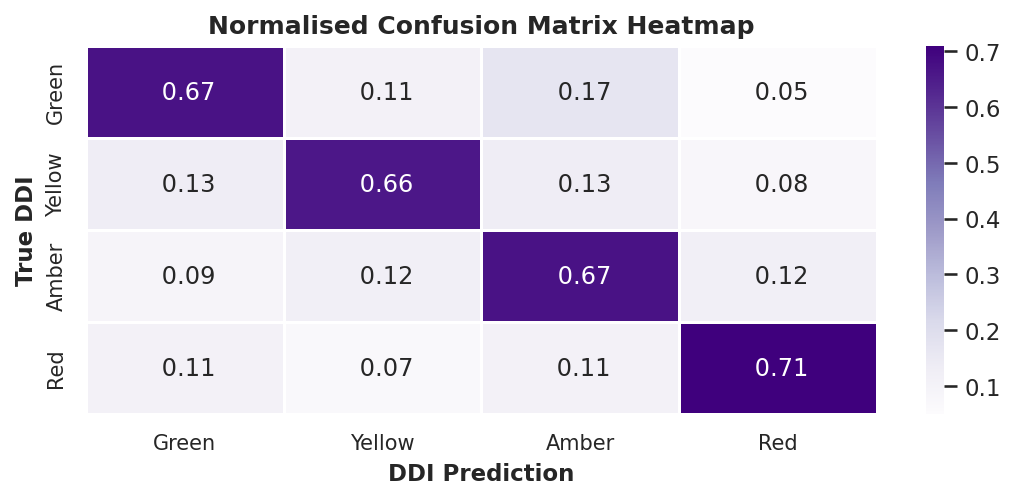

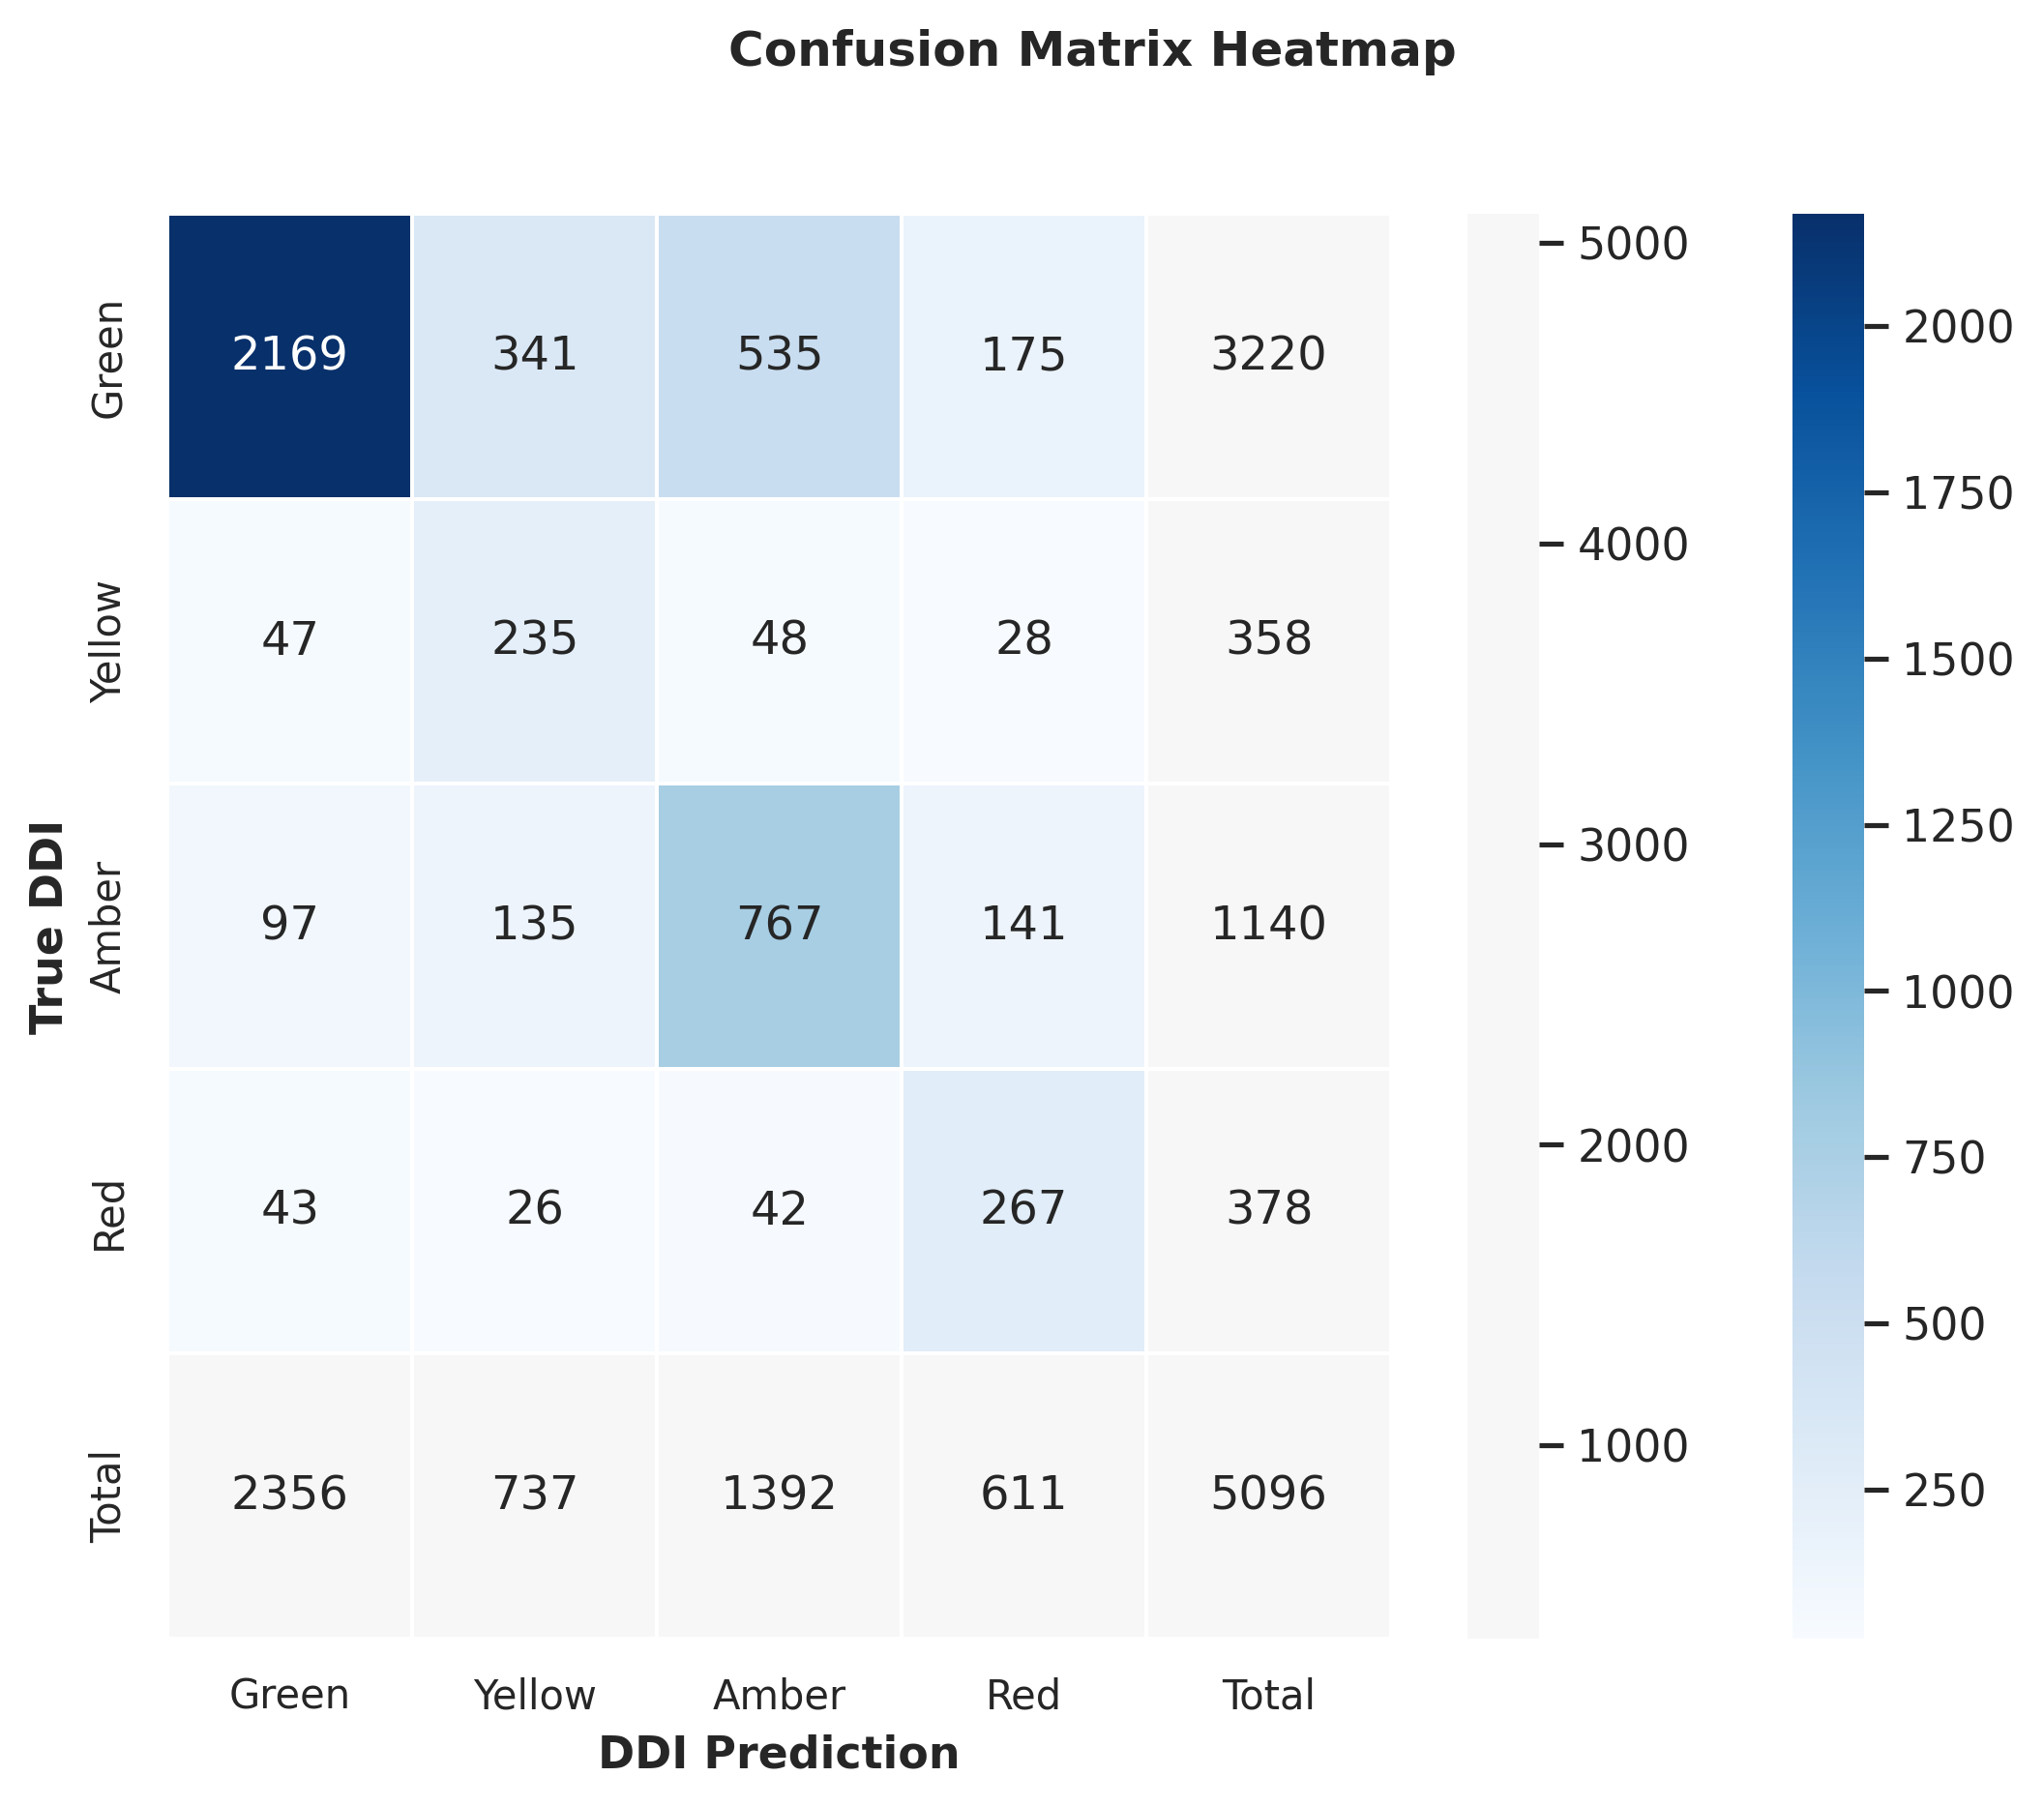

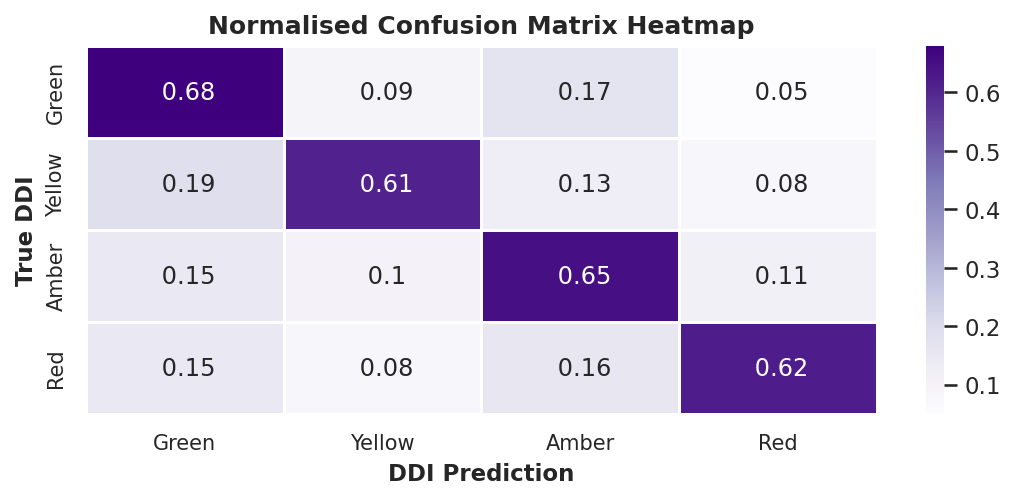

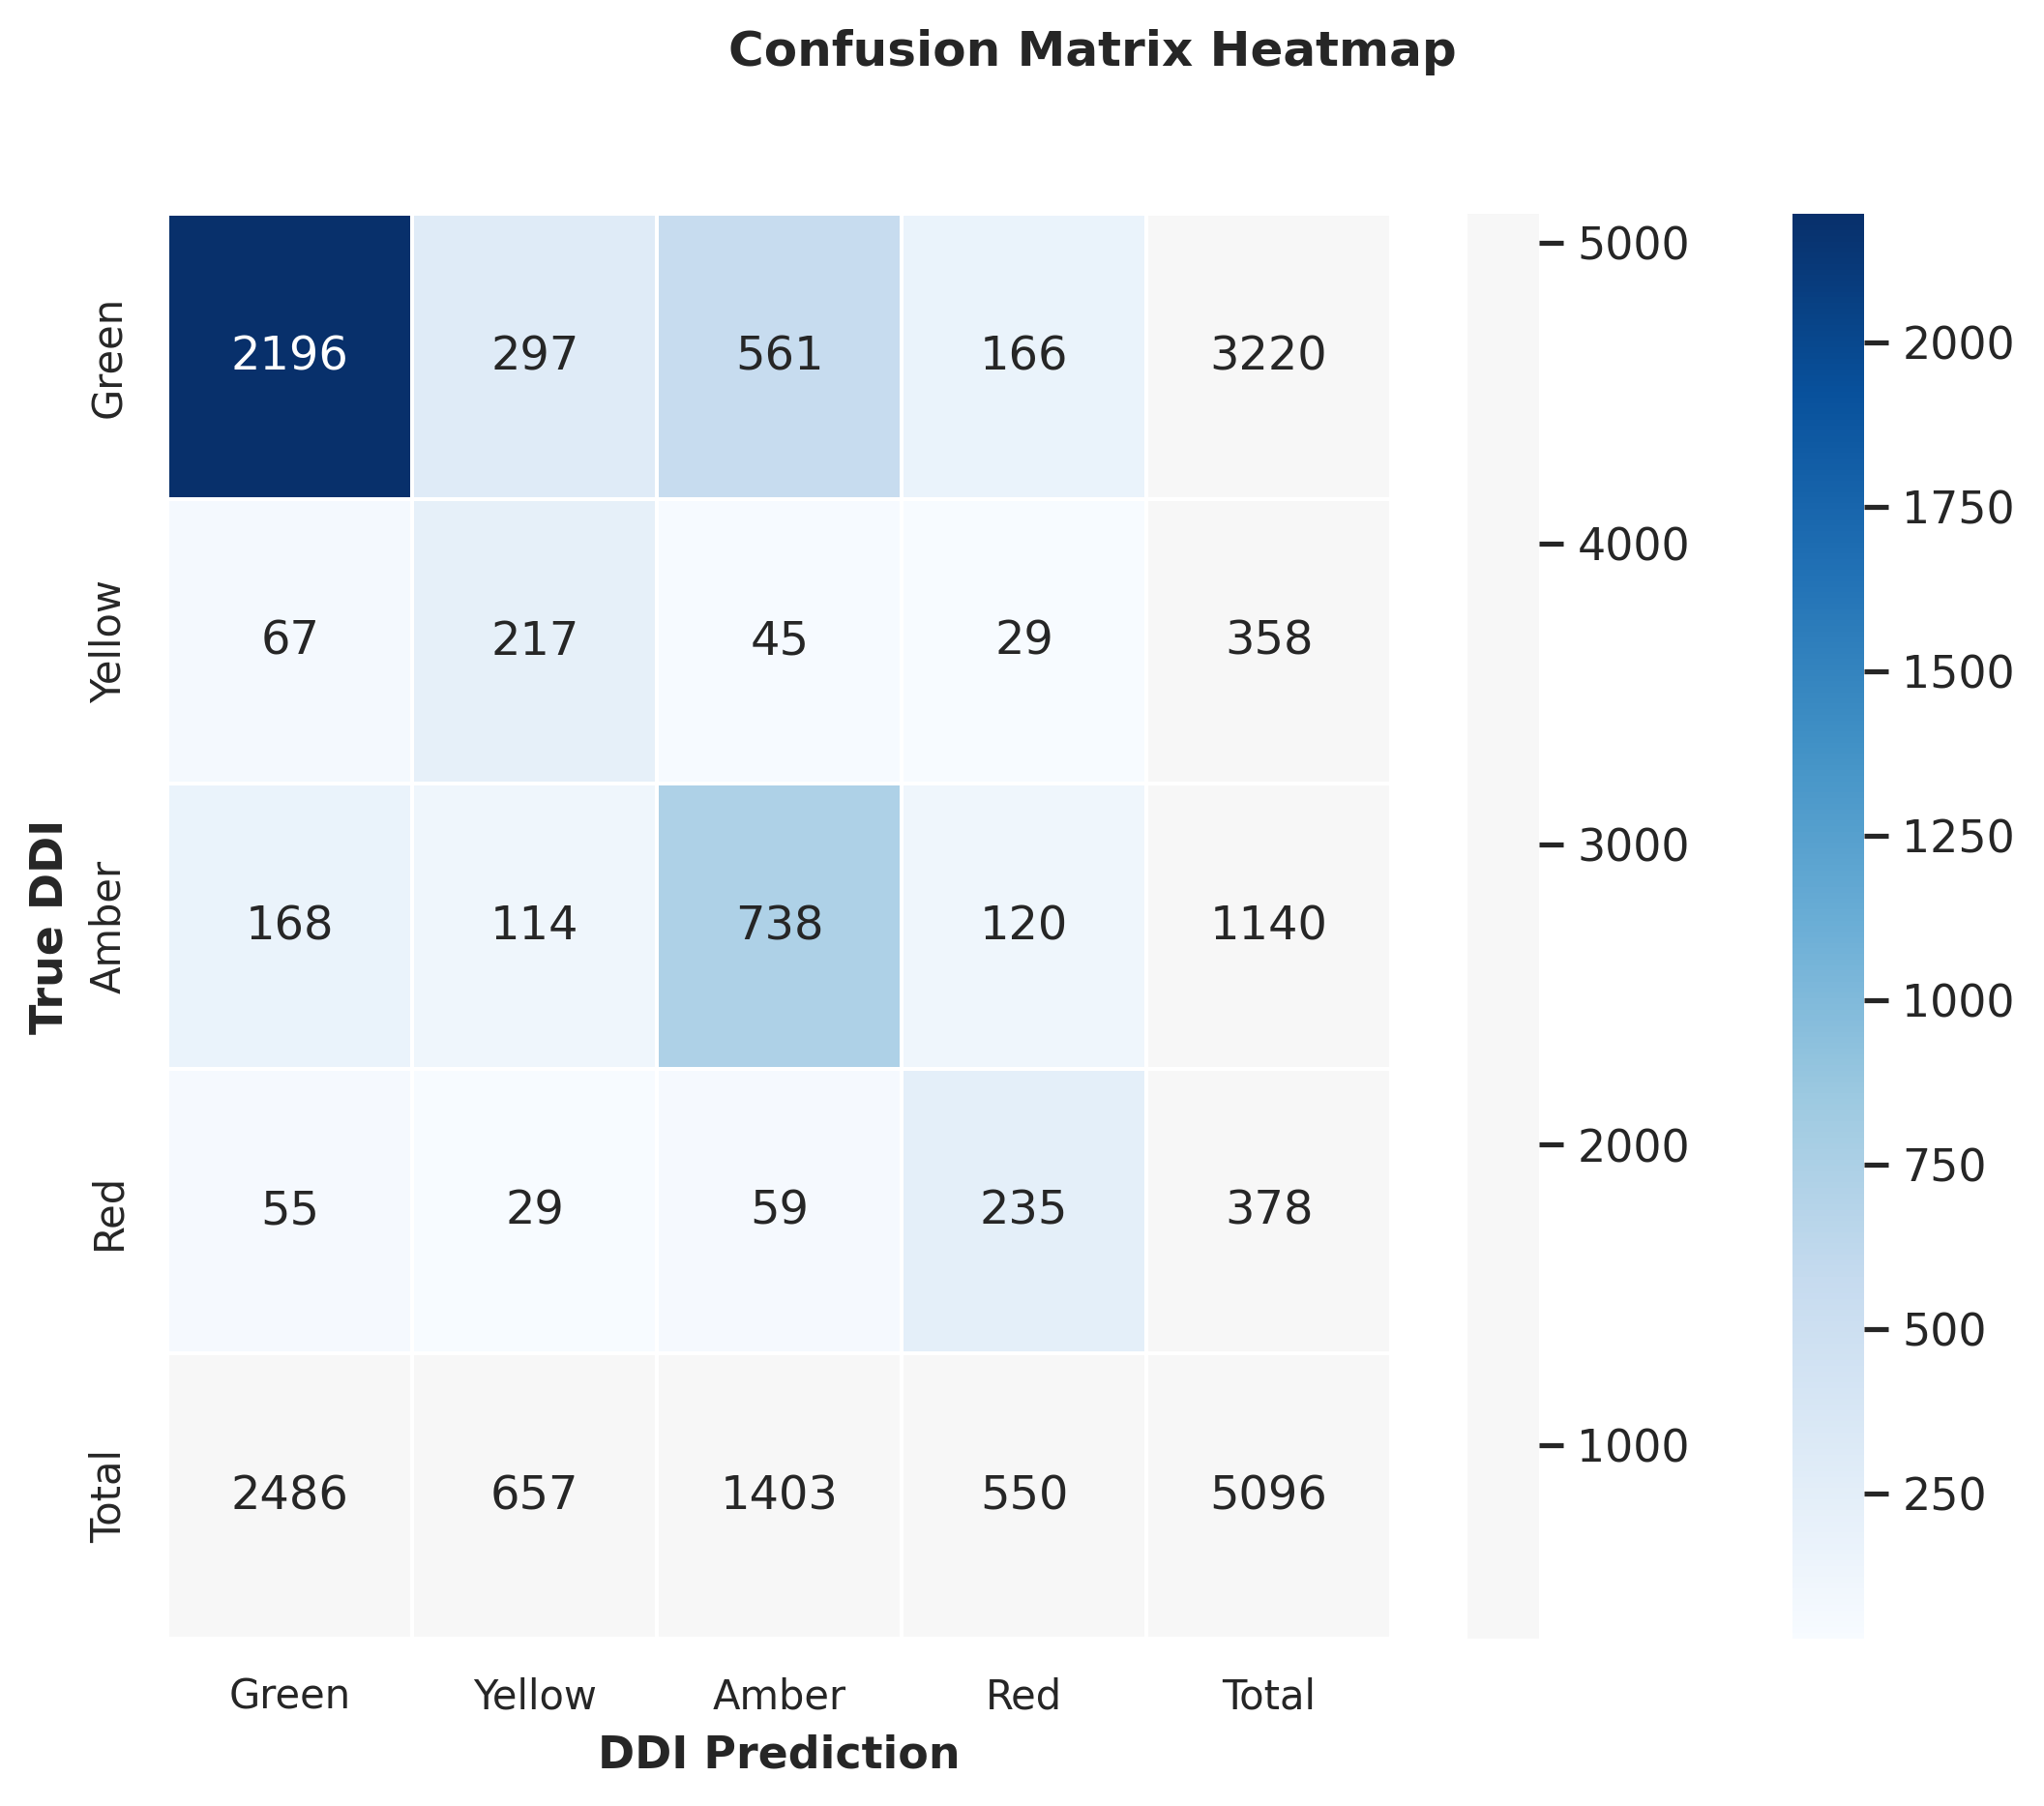

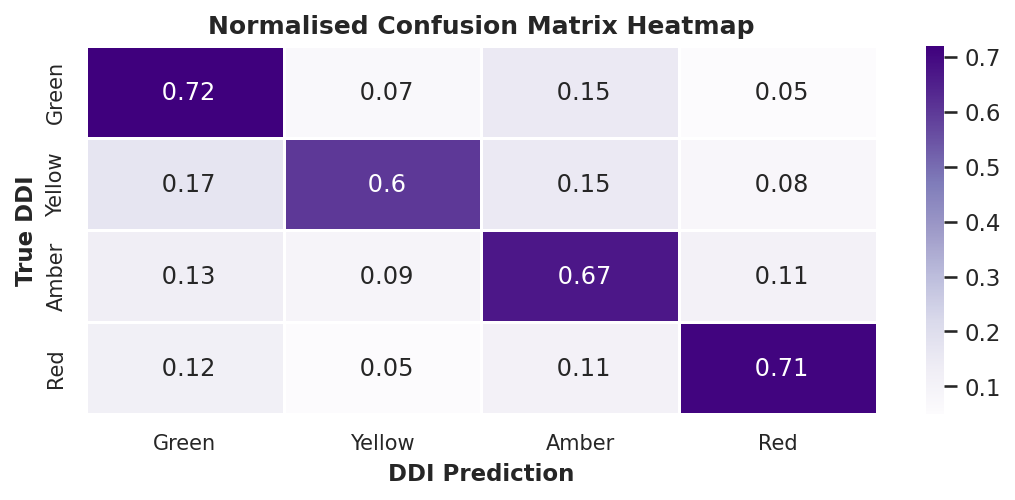

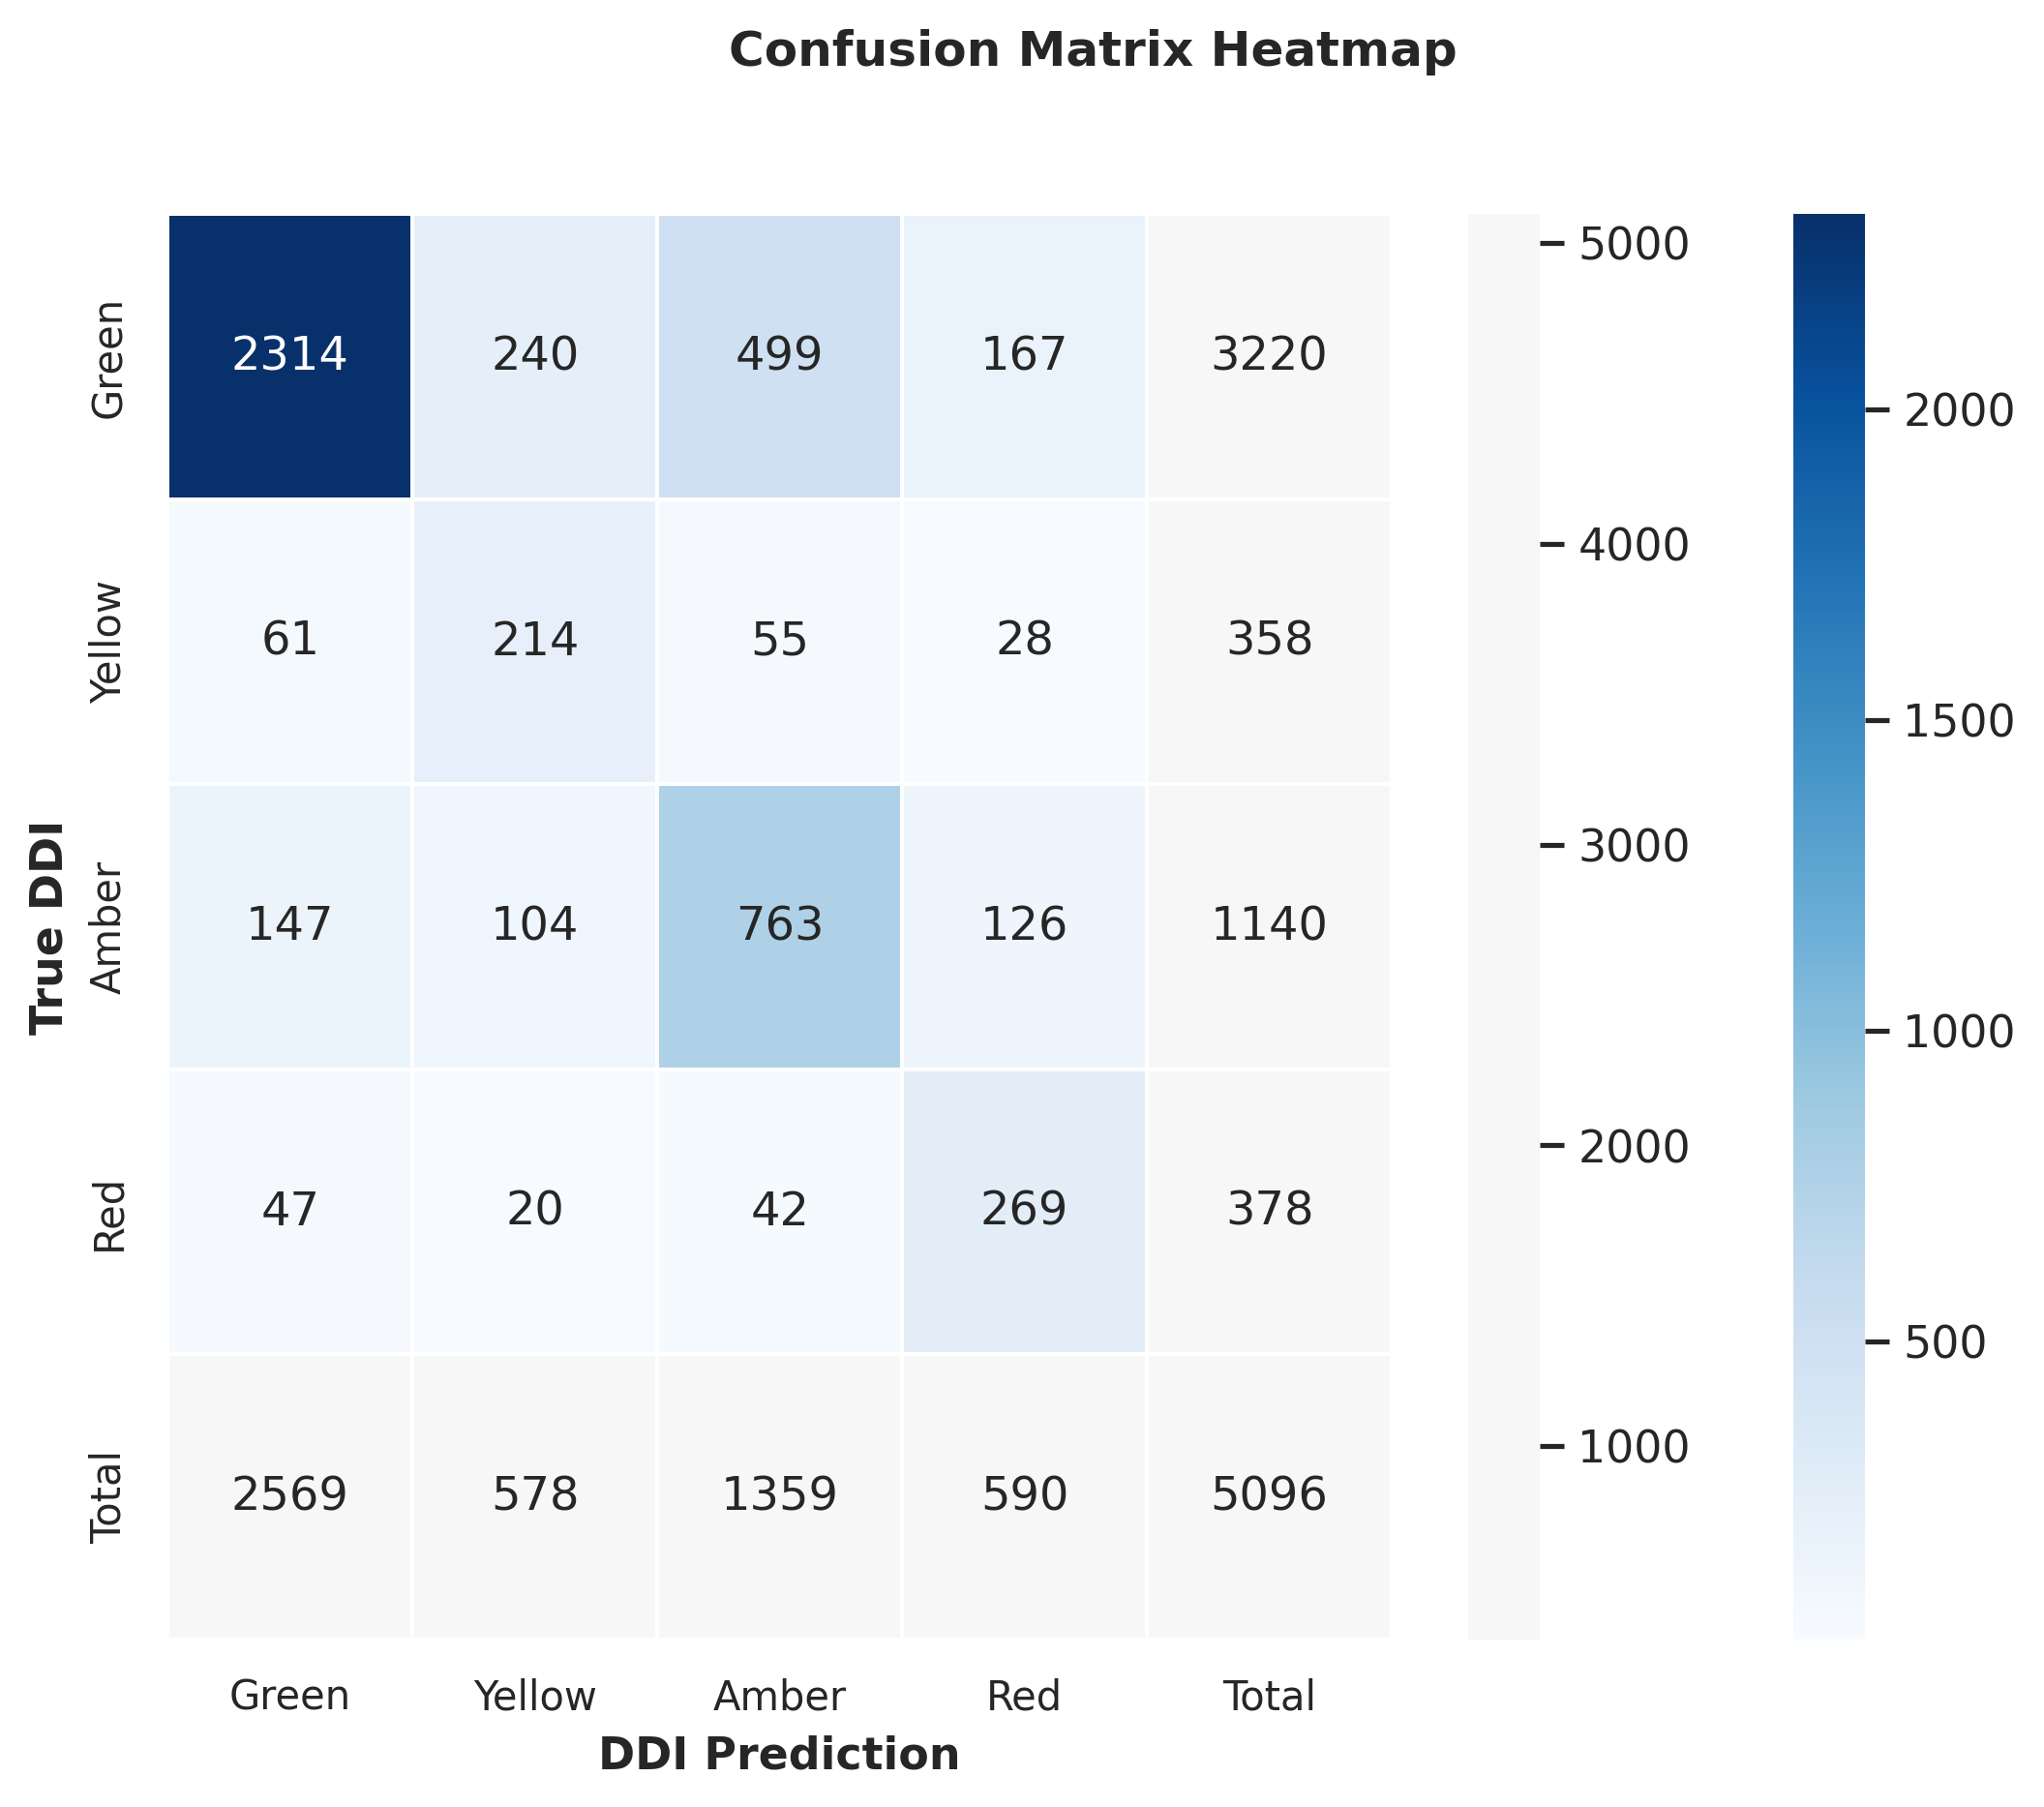

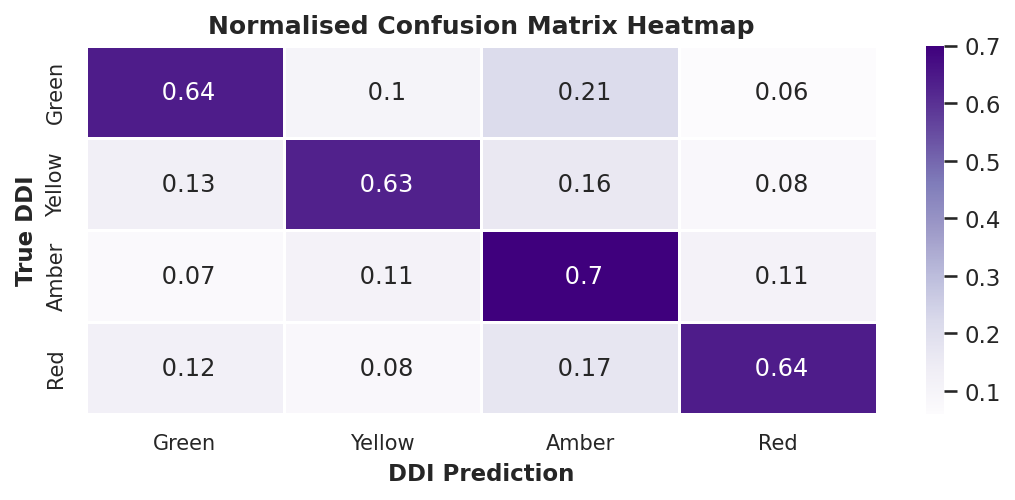

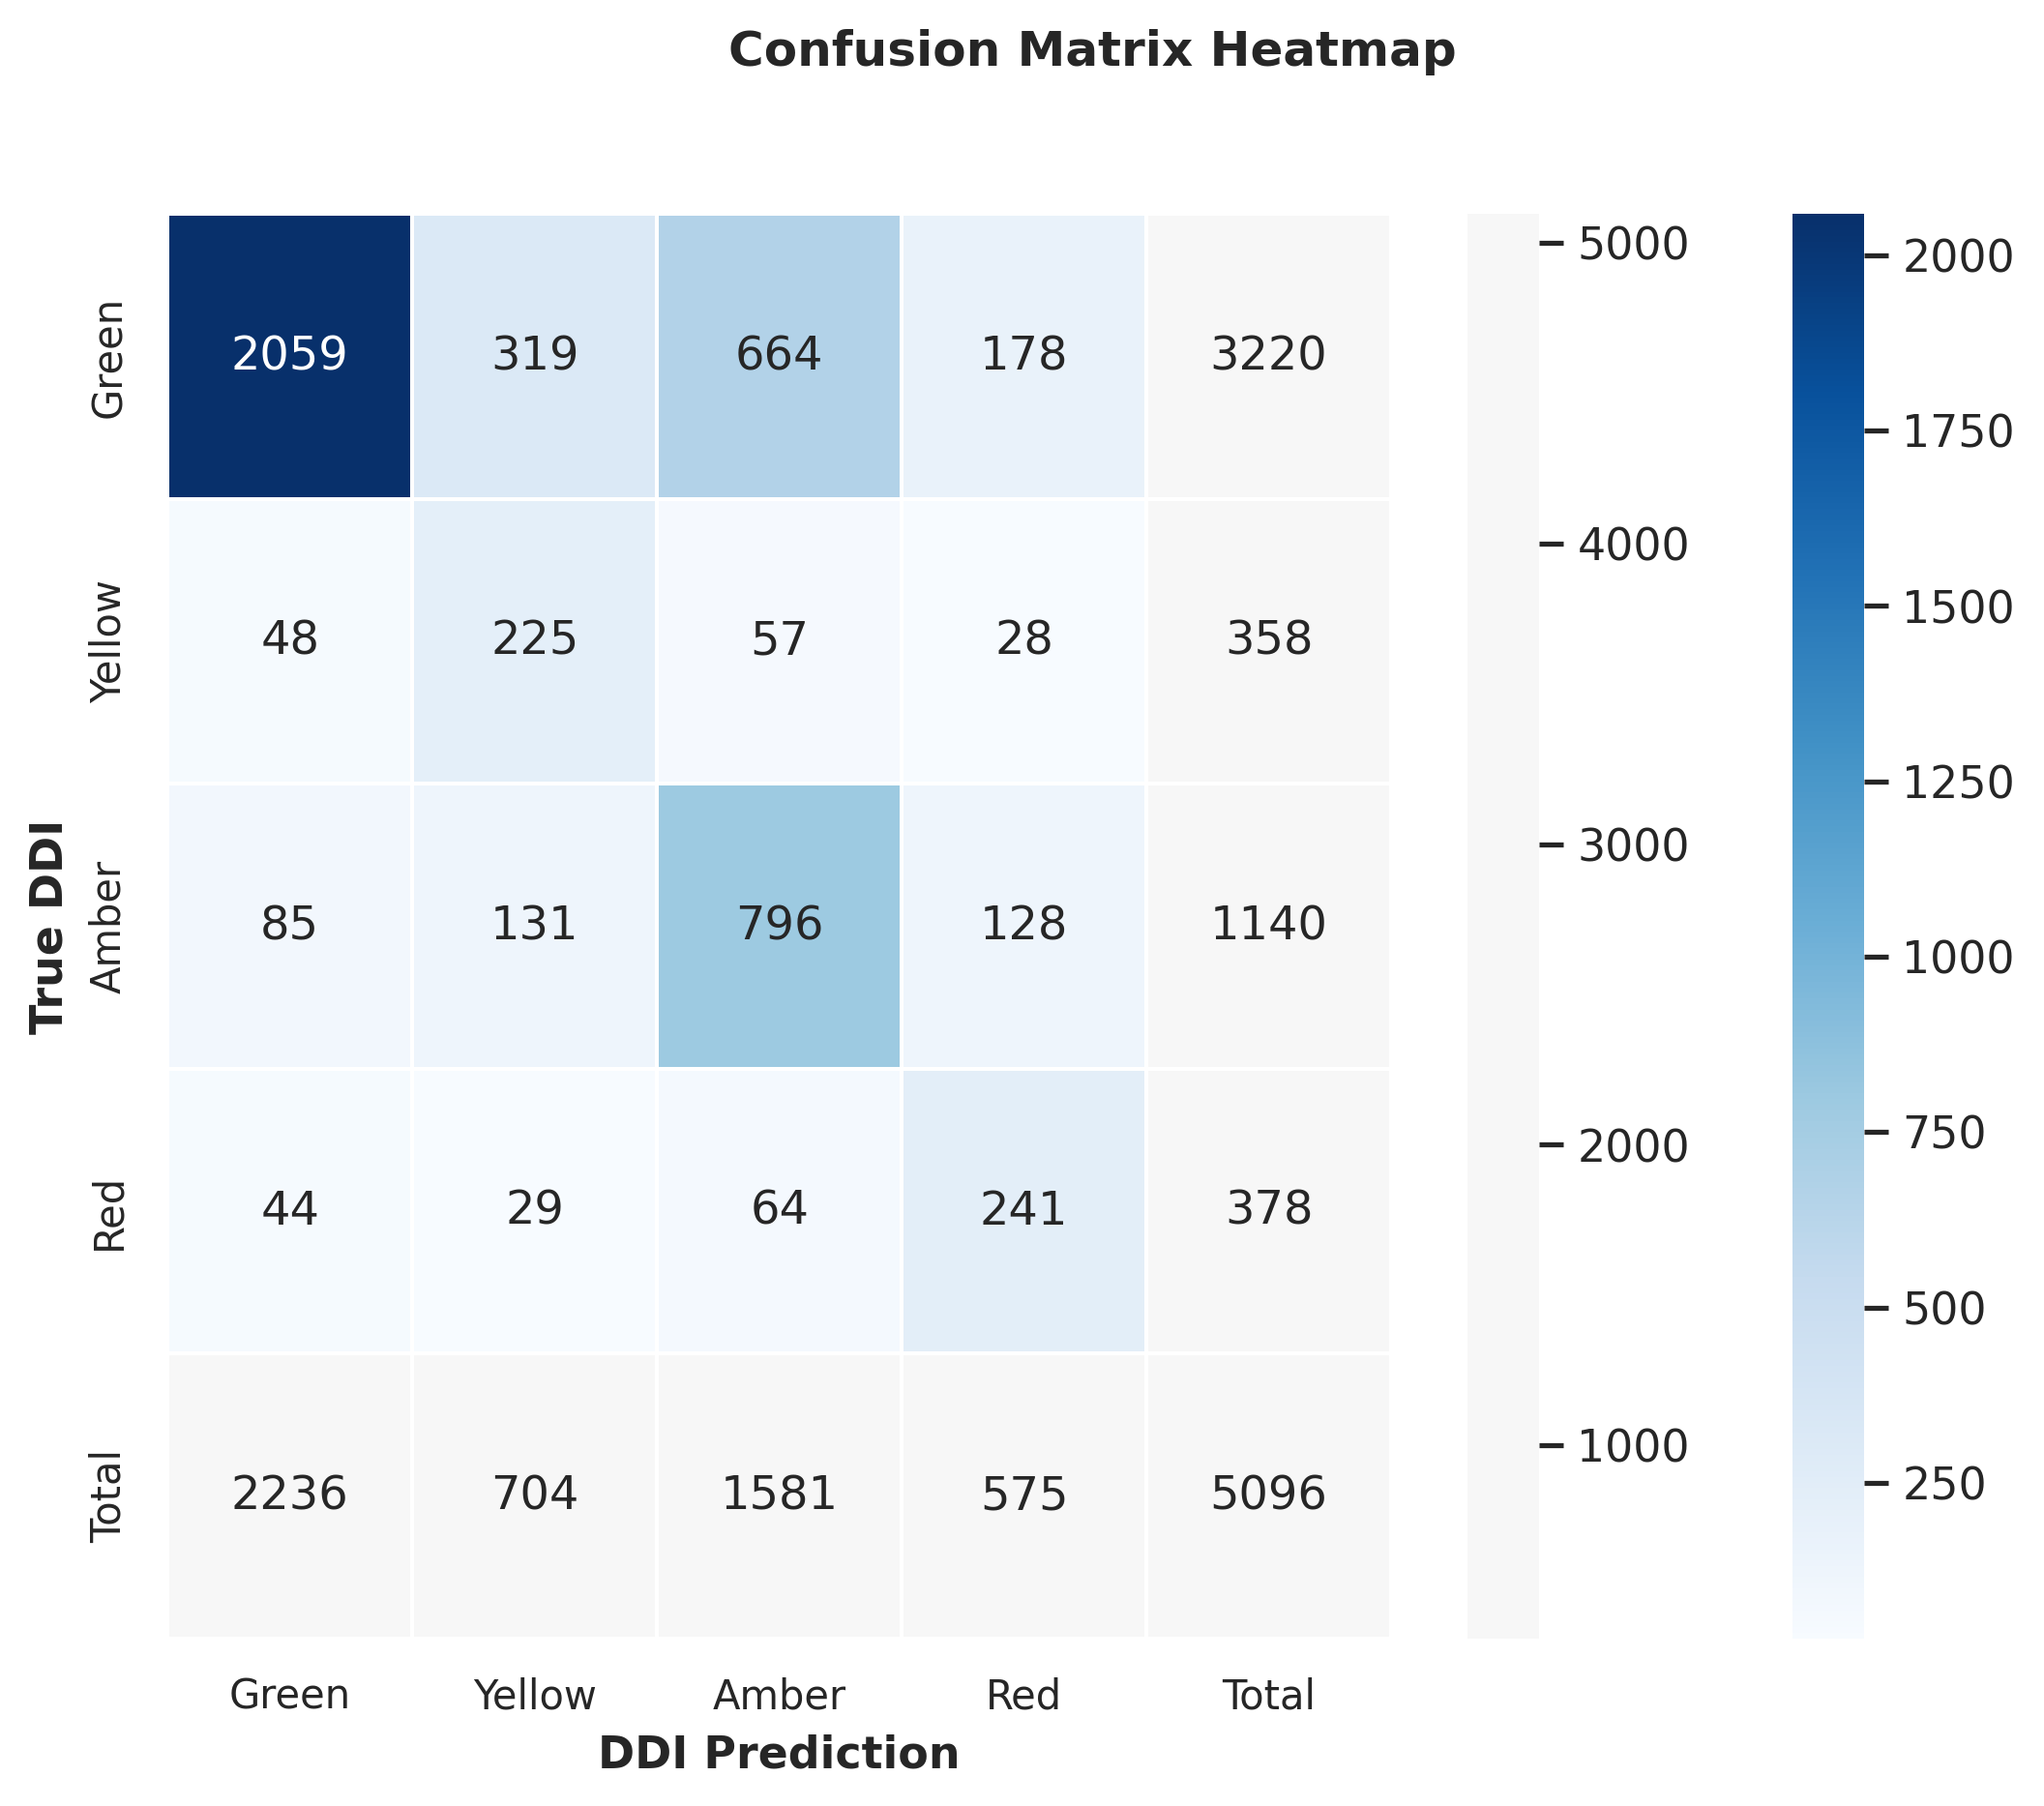

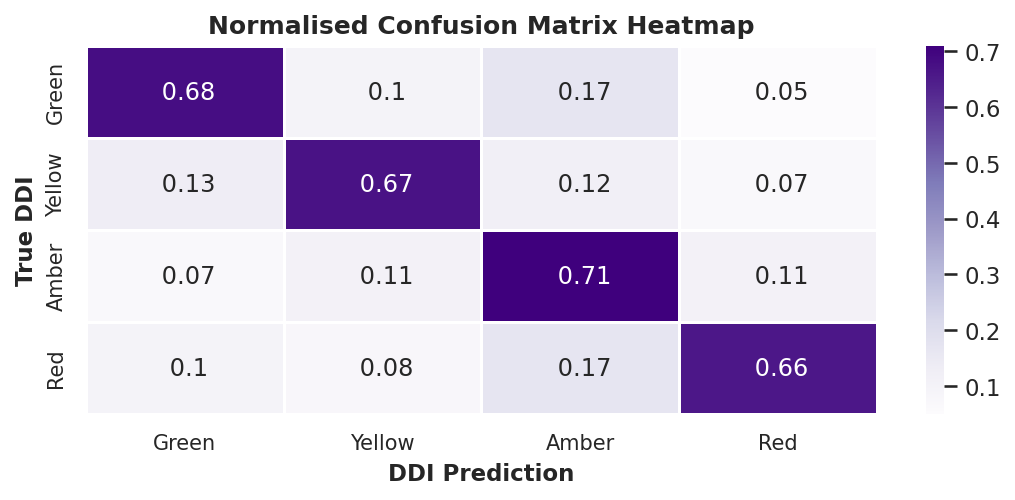

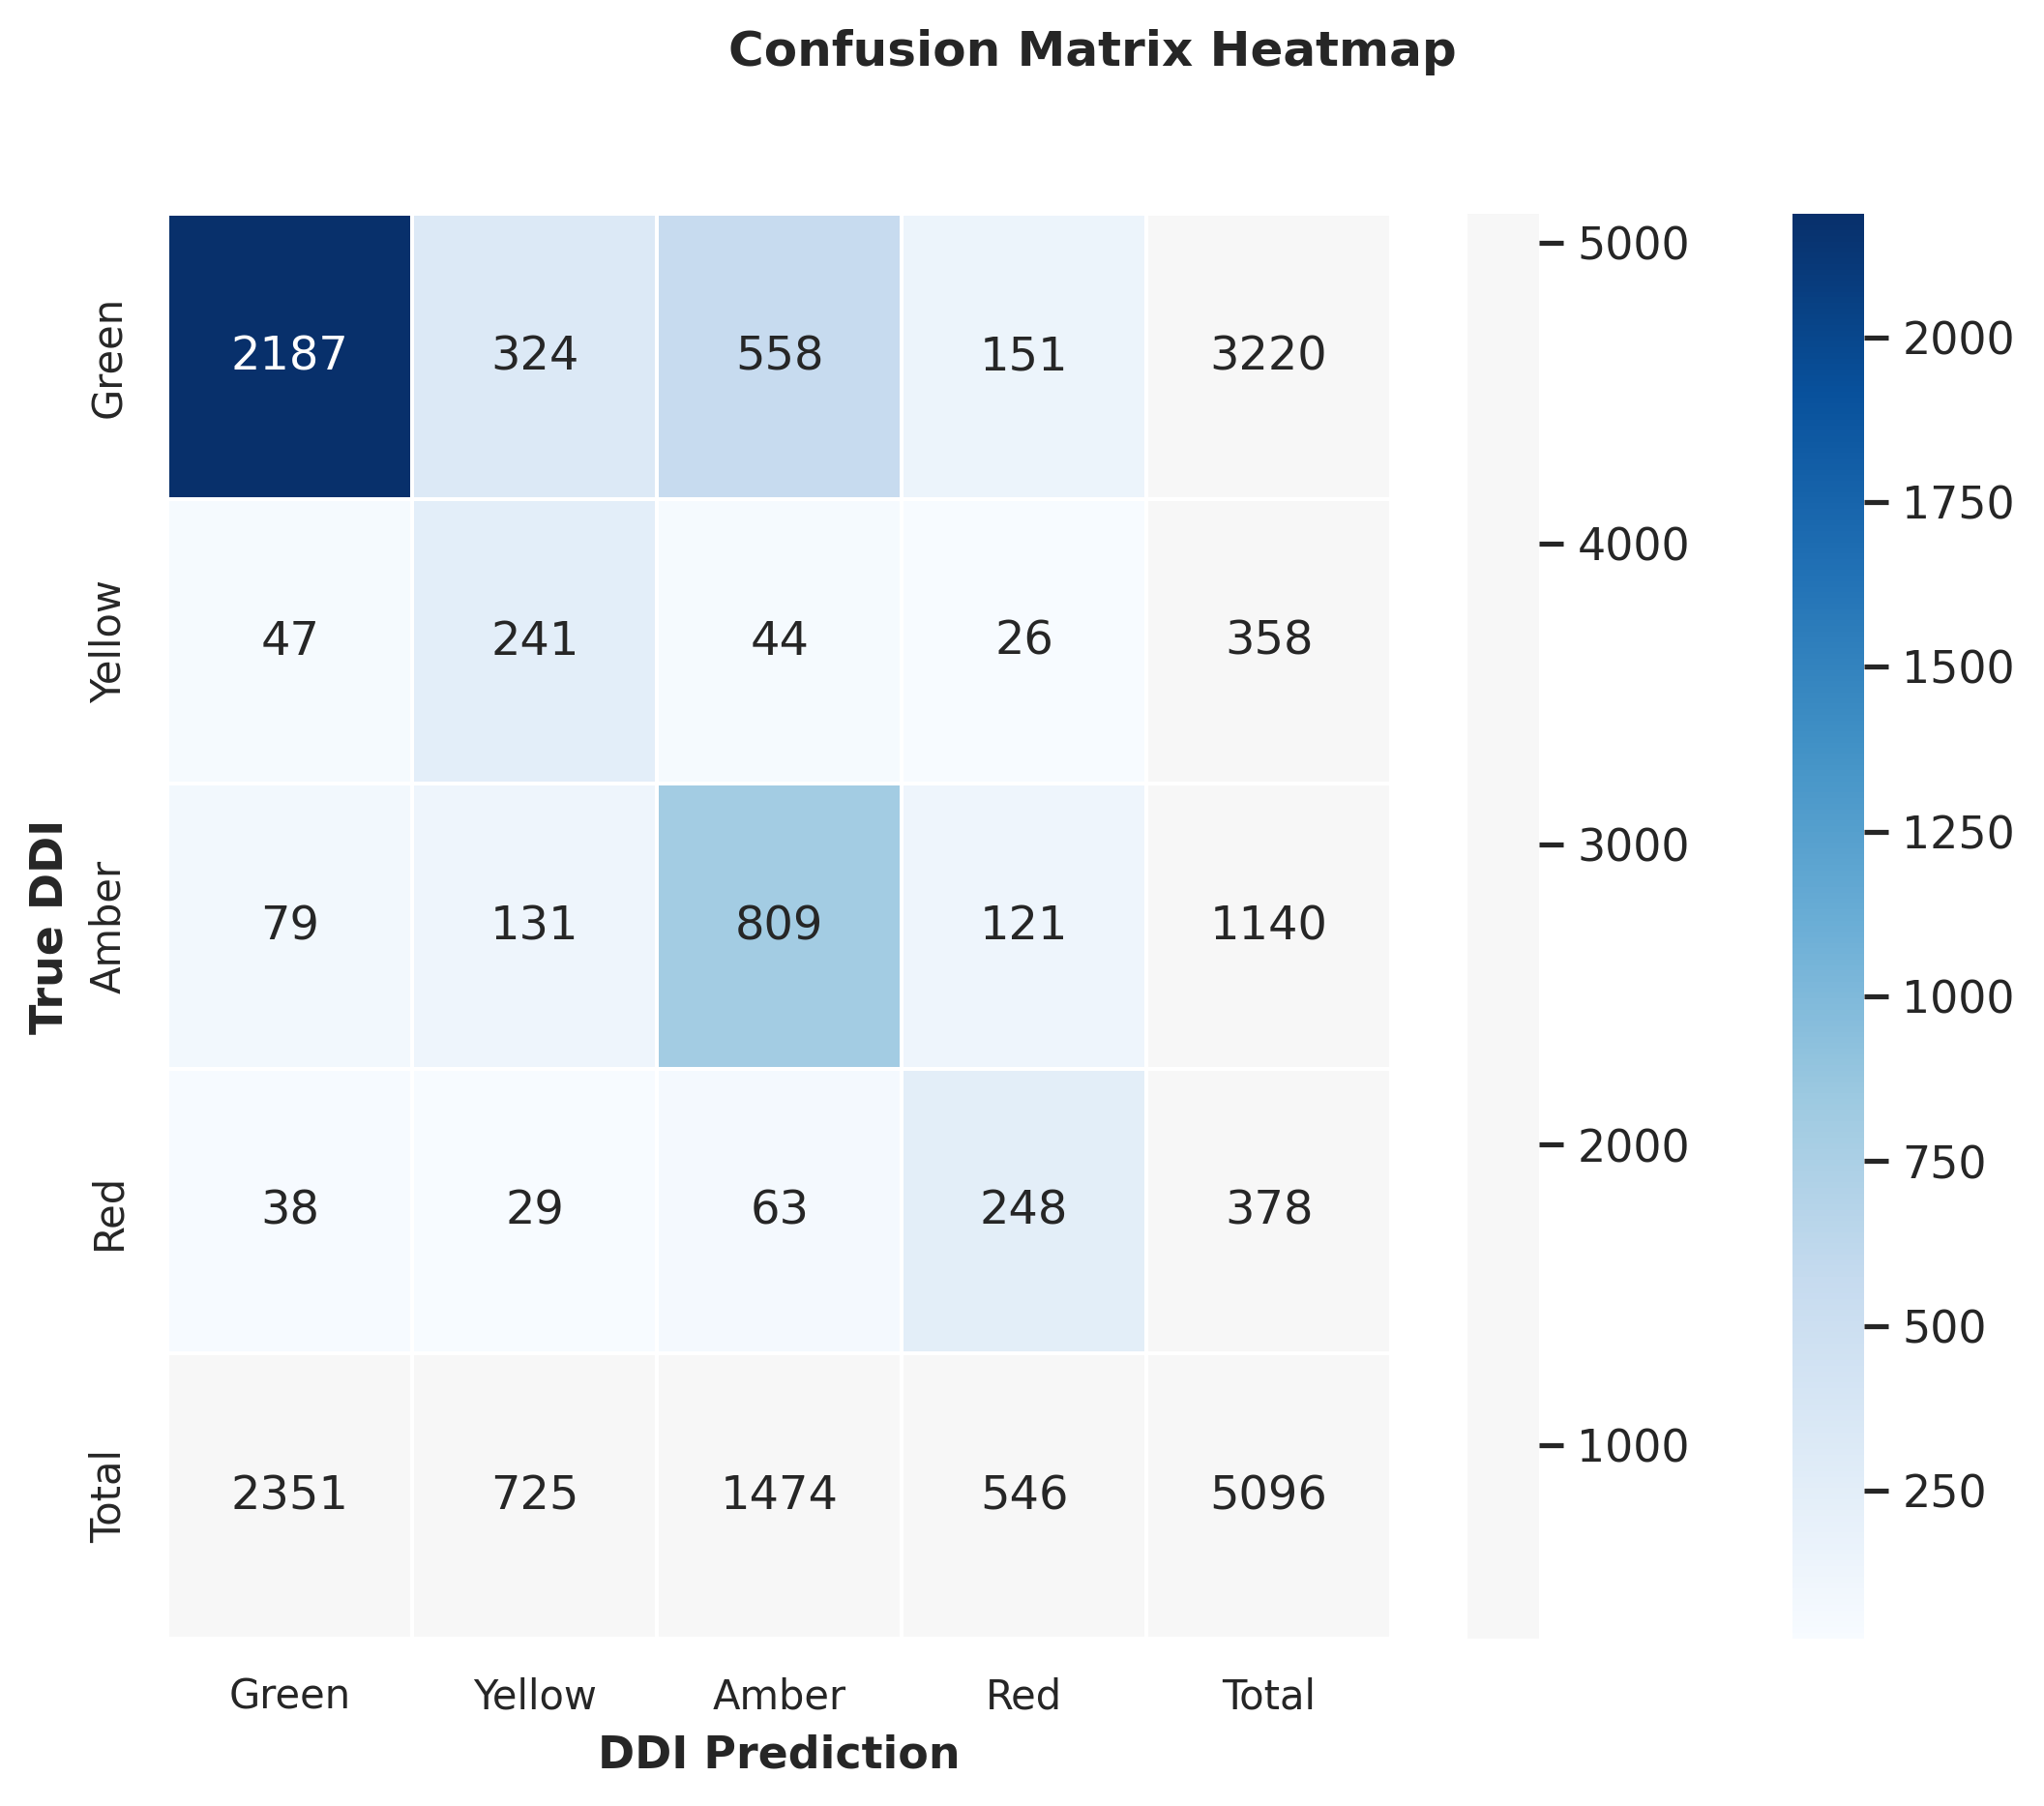

In [18]:
all_model_results, vote, confidence_score= DeepARV_evaluation()

In [19]:
avg_re = list(all_model_results.values())
#mean_df = pd.concat(avg_re).groupby(level=0).mean()


# check the same structure
assert all(df.shape == list(all_model_results.values())[0].shape for df in all_model_results.values())

# Stack DataFrames into a 3D array along a new axis (axis=2)
stacked_data = np.dstack([df.values for df in all_model_results.values()])

# Calculate the mean along the third axis (axis=2)
mean_values = np.mean(stacked_data, axis=2)

# Create a DataFrame with the calculated mean
mean_df = pd.DataFrame(mean_values, columns=list(all_model_results.values())[0].columns)

# Calculate the standard deviation along the third axis (axis=2)
std_deviation = np.std(stacked_data, axis=2)

# Create a DataFrame with the calculated standard deviation
std_dev_df = pd.DataFrame(std_deviation, columns=list(all_model_results.values())[0].columns)

# Display the result
print('Evaluation table for rows - Green (0), Yellow (1), Amber (2), Red (3) and weighted average (4)')
print('\n Macro average')
print(mean_df)
print('\n Standard deviation')
print(std_dev_df)

Evaluation table for rows - Green (0), Yellow (1), Amber (2), Red (3) and weighted average (4)

 Macro average
   accuracy  precision  sensitivity  specificity  f1-score  balanced accuracy
0   0.75480    0.91112      0.67856      0.88562   0.77740            0.78210
1   0.88514    0.33428      0.63240      0.90420   0.43658            0.76830
2   0.79740    0.53814      0.67946      0.83134   0.60018            0.75540
3   0.91200    0.43870      0.66666      0.93166   0.52896            0.79918
4   0.83730    0.75214      0.67464      0.87818   0.69540            0.77642

 Standard deviation
   accuracy  precision  sensitivity  specificity  f1-score  balanced accuracy
0  0.013234   0.016912     0.025193     0.026182  0.014924           0.012097
1  0.008089   0.018771     0.028791     0.010416  0.012672           0.010605
2  0.011300   0.020820     0.022068     0.016256  0.014920           0.010356
3  0.003275   0.014513     0.036245     0.003339  0.019710           0.017577
4  0.00804

<Figure size 3588x2018.25 with 0 Axes>

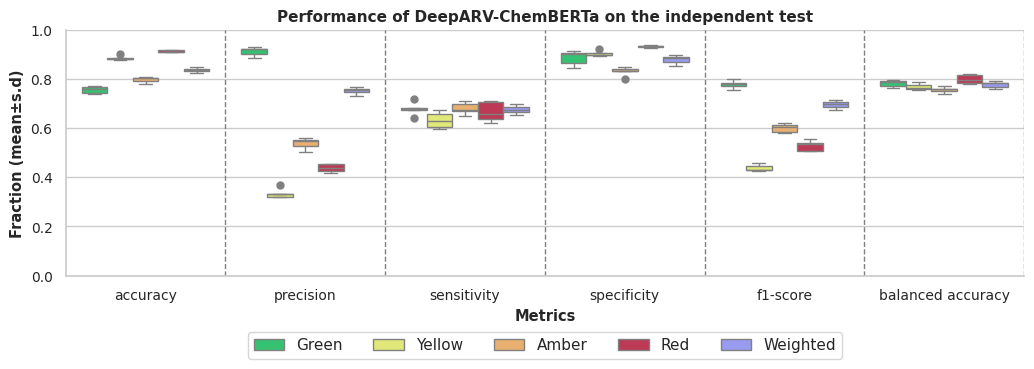

In [20]:
data = []
for model, df in all_model_results.items():
    for metric in df.columns:
        for class_ in df.index:
            data.append([f"Model {model + 1}", class_, metric, df.loc[class_, metric]])

# Create the DataFrame with MultiIndex columns
columns = ['Model', 'Class', 'Metrics', 'Value']
result_df_full = pd.DataFrame(data, columns=columns)

#result_df.to_excel('/content/drive/MyDrive/liverpool_hiv/Figure_Plot/DeepARV_revised_evaluation_result.xlsx')

result_df = result_df_full[result_df_full['Metrics'] !='Precision']
# Plotting

sns.set(style="whitegrid")

aspect_ratio =(16,9)
page_width_inch = 11.96
page_height_inch = 8.25/2
# Calculate the figure size
fig_width = page_width_inch
fig_height = fig_width * aspect_ratio[1] / aspect_ratio[0]

plt.figure(figsize=(fig_width,fig_height), dpi=300)

# set hue_order for the legend
hue_order = result_df['Class'].unique()

deepARV_plot = sns.catplot(data=result_df, x='Metrics', y='Value', hue='Class',
                           kind='box', hue_order = hue_order,
            height=3.5, aspect=3,
            boxprops=dict(edgecolor='grey'),
            whiskerprops=dict(color='grey'),
            capprops=dict(color='grey'),
             medianprops=dict(color='grey'),
            flierprops=dict(markerfacecolor='grey', markeredgecolor='grey'),
            palette=dict(Green='#1ED86F',
                           Yellow='#F1FA68',
                           Amber='#FCB15C',
                           Red='#D12548', Weighted="#8A8EFD"), legend_out=False)
deepARV_plot.set(ylim=(0, 1))
deepARV_plot.tick_params(axis='x', labelsize=10)
deepARV_plot.tick_params(axis='y', labelsize=10)

plt.title('Performance of DeepARV-ChemBERTa on the independent test', size = 11,
          fontweight='bold')
plt.xlabel('Metrics', size=10.5,fontweight='bold')
plt.ylabel('Fraction (mean' + (u'\xb1') + 's.d)', size=10.5,fontweight='bold')
plt.tight_layout()

# Add vertical lines between metrics
for metric, position in zip(result_df['Metrics'].unique(), range(len(result_df[
    'Metrics'].unique()))):
    plt.axvline(x=position + 0.5, color='grey', linestyle='--', linewidth=1)

# legend box to the bottom
deepARV_plot.ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.37),
                       ncol=5)


# Show the plot
deepARV_plot.savefig('content\evaluation_result', dpi=300)
plt.show()

## AUROC

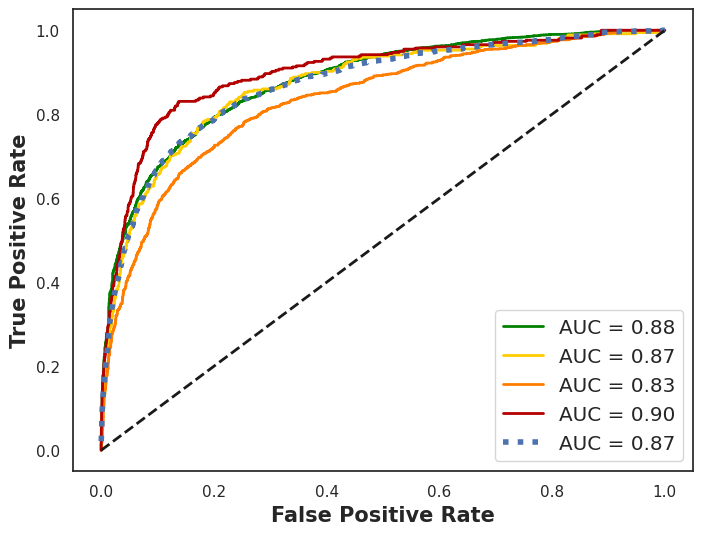

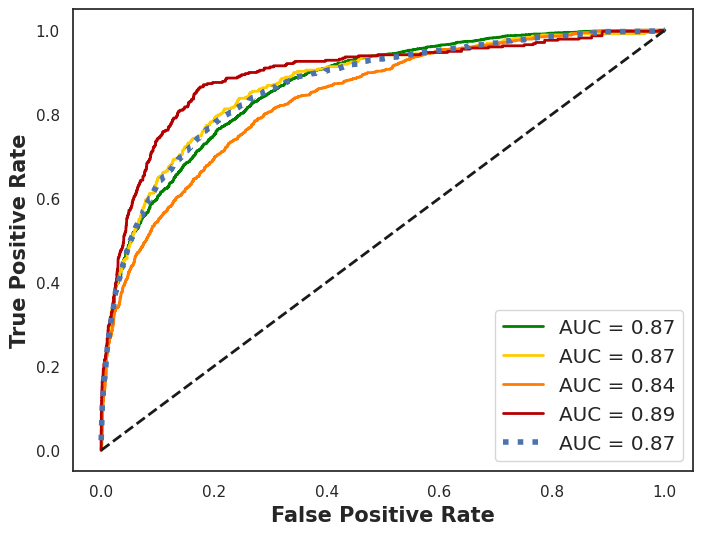

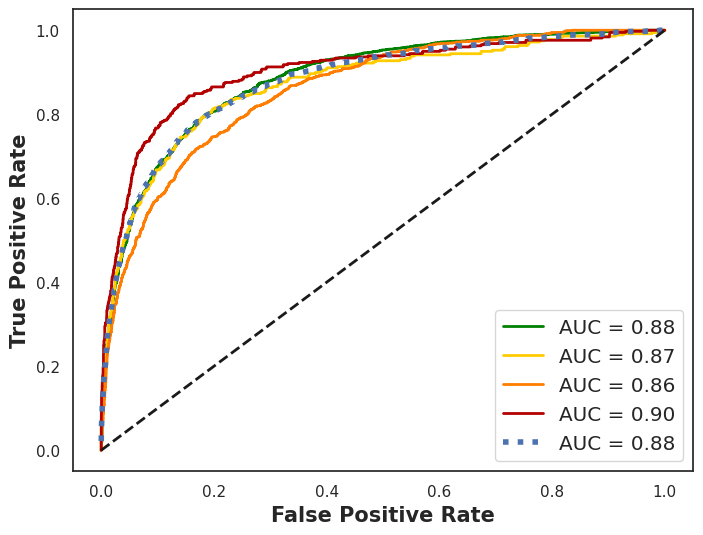

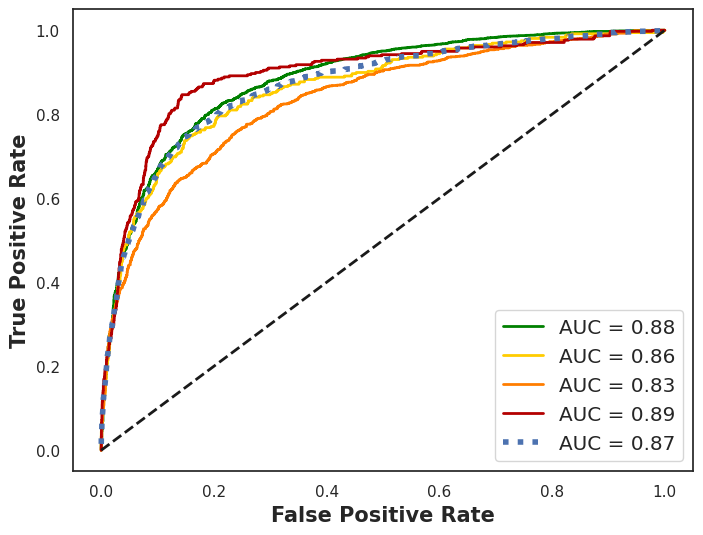

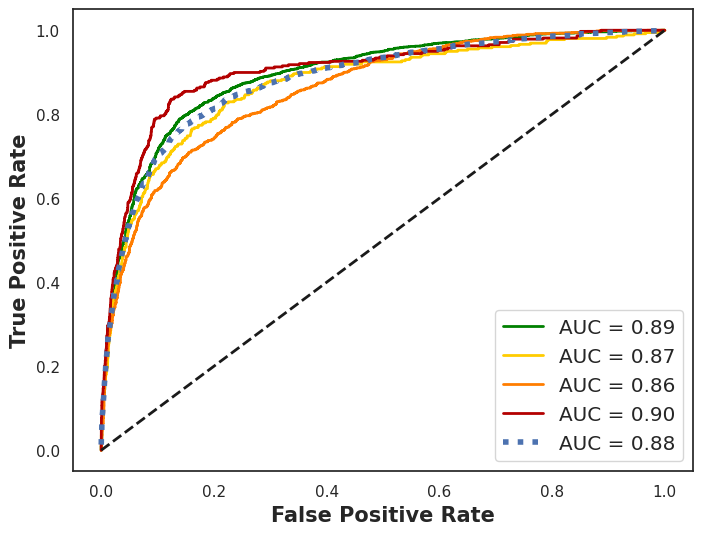

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
sns.set(style="white")

y_test =  np.load('/content/drive/MyDrive/liverpool_hiv/chemberta/y_test.npy')

# Assuming y_test is a 1D array of class labels
label_binarizer = LabelBinarizer()
y_test = label_binarizer.fit_transform(y_test)

def plotAUROC(soft_vote, y_test, save_filename=None):
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  n_classes = 4
  ensemble_proba = soft_vote

  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ensemble_proba[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute macro-average ROC curve and ROC area
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Interpolate all ROC curves
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Average and calculate AUC
  mean_tpr /= n_classes
  macro_auc = auc(all_fpr, mean_tpr)

  fig, ax = plt.subplots(figsize=(8, 6))

  # Class name
  class_label = ['Green', 'Yellow', 'Amber', 'Red']
  class_colour = {0: 'Green', 1: (1.0, 0.8, 0.0), 2: (1.0, 0.49, 0.0),
                  3: (0.7, 0.0, 0.0)}

  # Plot each class's ROC curve
  for i in range(n_classes):
      ax.plot(fpr[i], tpr[i], lw=2,
              label='AUC = {:.2f}'.format(roc_auc[i], class_label[i]),
              color=class_colour.get(i, 'blue'))

  # Plot macro-average ROC curve
  ax.plot(all_fpr, mean_tpr,
          label='AUC = {:.2f}'.format(macro_auc),
          linestyle=':', linewidth=4)

  ax.plot([0, 1], [0, 1], 'k--', lw=2)
  ax.set_xlabel('False Positive Rate', size=15, fontweight='bold')
  ax.set_ylabel('True Positive Rate', size=15, fontweight='bold')
  ax.legend(loc='lower right', fontsize='large')

  if save_filename is not None:
      fig.savefig(save_filename, dpi=300)
      plt.show()
      plt.close(fig)
  else:
      plt.show()

for i in range(5):
    plotAUROC(confidence_score[i], y_test, save_filename=f'chemberta_roc_{i}.png')


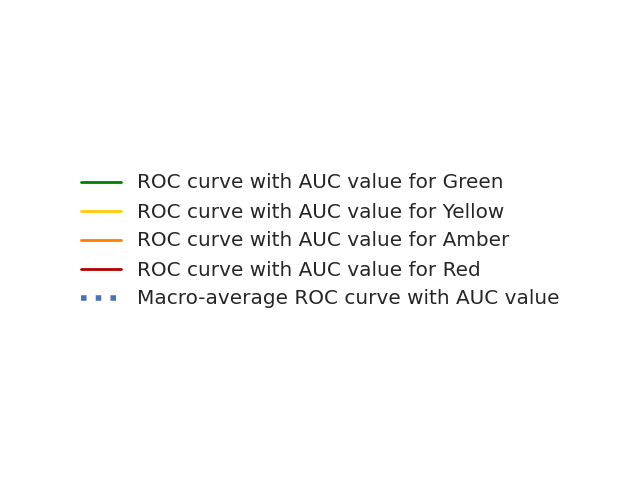

In [22]:
def plotLegend():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_axis_off()
    # Class name and colour
    class_label = ['Green', 'Yellow', 'Amber', 'Red']
    class_colour = {0: 'Green', 1: (1.0, 0.8, 0.0), 2: (1.0, 0.49, 0.0),
                    3: (0.7, 0.0, 0.0)}

    for i in range(len(class_label)):
        ax.plot([], [], lw=2,
                label='ROC curve with AUC value for {}'.format(class_label[i]),
                color=class_colour.get(i, 'blue'))

    ax.plot([], [], linestyle=':', linewidth=4,
            label='Macro-average ROC curve with AUC value'.format(0.0))

    legend = ax.legend(loc='center', fontsize='large', frameon=False)
    legend.get_frame().set_edgecolor('grey')
    plt.savefig('legend_roc.png', dpi=300)
    plt.show()

# Call plotLegend to display the legend box
plotLegend()

## Confusion matrix

Mean:
[[0.6786 0.0946 0.1748 0.052 ]
 [0.1506 0.6322 0.1392 0.0776]
 [0.101  0.1078 0.6794 0.1116]
 [0.1202 0.0706 0.1428 0.6668]]

Standard Deviation:
[[0.02542912 0.01078147 0.01701058 0.00275681]
 [0.0234316  0.0286524  0.01466151 0.00257682]
 [0.03116408 0.01049571 0.02227644 0.00677052]
 [0.01486472 0.00932952 0.02633932 0.03614637]]


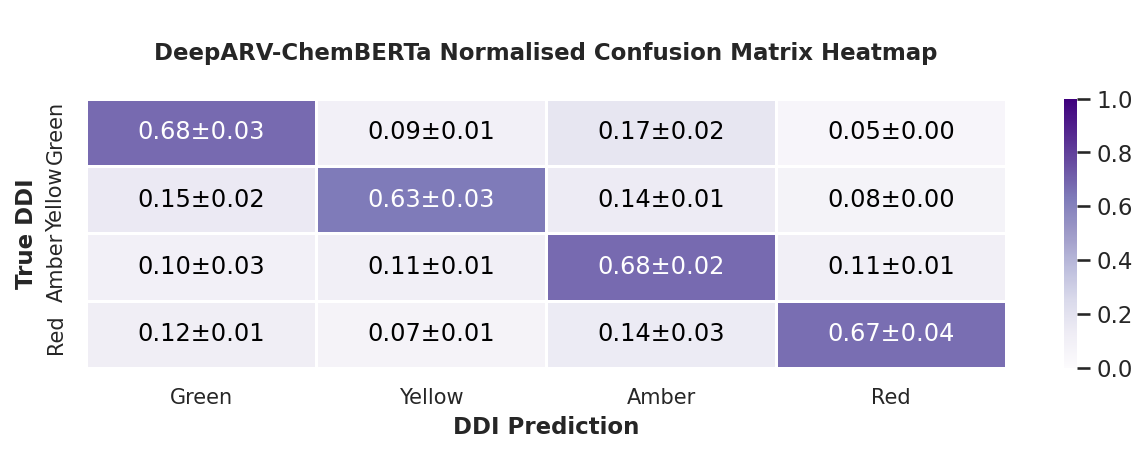

In [23]:
# plot mean of normalised cf from all models
y_test =  np.load('/content/drive/MyDrive/liverpool_hiv/chemberta/y_test.npy')
cf_dict = {}
cf_matrix_dict = {}
for i in range(5):
  ana_results = pd.read_pickle('result_' + str(i) +'.pkl')
  cf_matrix = tf.math.confusion_matrix(y_test,ana_results.final_vote, 4)
  cf_matrix_dict[i] = cf_matrix
  #cf_matrix = np.array(cf_matrix)
  cf_matrix_cal = np.array(cf_matrix)/np.sum(cf_matrix,axis=1)[:,np.newaxis]
  cf_matrix_normalised = np.around(cf_matrix_cal,3)
  cf_dict[i] = cf_matrix_normalised

# mean and standard deviation
mean_array = np.mean([cf_dict[key] for key in sorted(cf_dict.keys())], axis=0)
std_arr = np.std([cf_dict[key] for key in sorted(cf_dict.keys())], axis=0)
cf_matrix_mean = np.mean([cf_matrix_dict[key] for key in sorted(cf_matrix_dict.keys())], axis=0)

# Display the results
print("Mean:")
print(mean_array)
print("\nStandard Deviation:")
print(std_arr)

# Update final dictionary result
cf_dict['avg'] = mean_array
cf_dict['std'] = std_arr

# Combine mean and standard deviation into a single array
combined_array = np.vstack([mean_array, std_arr])
cf_matrix_normalised = mean_array

# Convert the combined array
combined_str_array = np.array(
    [f"{avg:.2f}±{std:.2f}" for avg,
     std in zip(mean_array.flatten(), std_arr.flatten())]).reshape(mean_array.shape)

group_counts = [value for value in cf_matrix_normalised.flatten()]
labels = [f"{v1}"
          for v1 in
          group_counts]
labels= np.asarray(labels).reshape(len(cf_matrix_normalised),
                                    len(cf_matrix_normalised))
sns.set(font_scale=1)


xy_label = ['Green','Yellow','Amber','Red']

aspect_ratio =(4, 3/2)
page_width_inch = 8.5
page_height_inch = 11
fig_width = page_width_inch
fig_height = fig_width * aspect_ratio[1] / aspect_ratio[0]
plt.figure(figsize=(fig_width,fig_height), dpi=150)

# Create the heatmap
res = sns.heatmap(data=cf_matrix_normalised, cmap='Purples',
                  linewidths=0.5, linecolor='white',
                  xticklabels=xy_label, yticklabels=xy_label, vmin=0, vmax=1)
for i in range(len(xy_label)):
    for j in range(len(xy_label)):
      text_color = "white" if cf_matrix_normalised[i,j] > 0.4 else "black"
      res.text(j + 0.5, i + 0.5, combined_str_array[i, j],
                 ha='center', va='center', fontsize=11.5, color=text_color)
res.tick_params(axis='x', labelsize=10)
res.tick_params(axis='y', labelsize=10)
plt.xlabel('DDI Prediction', size=11,fontweight='bold')
plt.ylabel('True DDI', size=11,fontweight='bold')
plt.title('\n DeepARV-ChemBERTa Normalised Confusion Matrix Heatmap \n', fontsize=11,
          fontweight='bold')
plt.tight_layout()
plt.savefig('CM_DeepARV_Chemberta', dpi=300)